In [1]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as  nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
import time
from tqdm.autonotebook import tqdm, trange
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

companies = ['GAZP', 'SBER', 'LKOH', 'GMKN', 'MGNT',
       'TATN', 'NVTK', 'SNGS', 'PLZL', 'SNGSP',
       'PIKK', 'ROSN', 'SBERP', 'CHMF', 'NLMK',
       'IRAO', 'YNDX', 'ALRS', 'RUAL', 'MTSS',
       'MAGN', 'PHOR', 'RTKM', 'VTBR', 'TATNP',
       'TCSG', 'AGRO', 'OZON', 'AFLT', 'AFKS',
       'FEES', 'TRNFP', 'CBOM', 'VKCO', 'ENPG',
       'SGZH', 'FIVE', 'POLY', 'MOEX', 'GLTR',
       'HYDR', 'FIXP']

/tmp/ipykernel_7139/3897907851.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
path = '~/Рабочий стол/ДИПЛОМ НОУТБУКИ/DL forcasitng diplom/Данные Мосбиржа/Total_MOEX_hourly_with_time_df'
total_df = pd.read_csv(path)


# total_df.tradetime = total_df.close
# total_df.drop(['close', 'pr_close'], 1, inplace = True)
# total_df.rename(columns={'tradetime':'close'}, inplace=True)

data = total_df[total_df.secid == 'SBER'].drop('secid', 1)#.set_index('tradedate')


/tmp/ipykernel_7139/4226854838.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = total_df[total_df.secid == 'SBER'].drop('secid', 1)#.set_index('tradedate')


In [3]:
# train_data = data[ : round(data.shape[0]*0.53) ]
# val_data = data[ round(data.shape[0]*0.60) : ]

train_data = data[ : round(data.shape[0]*0.80) ].to_numpy()

val_data = data[ round(data.shape[0]*0.80) : ].to_numpy()

In [4]:
train_data = np.array(train_data)
val_data = np.array(val_data)

for i in range(data.shape[1]):
    if i == 0:
        train_series = train_data[:,i].reshape(-1, 1)
        val_series = val_data[:,i].reshape(-1, 1)
    
        scaler_star = StandardScaler()
        train_series = scaler_star.fit_transform(train_series)
        val_series = scaler_star.transform(val_series)
    
        train_data[:, i] = train_series.flatten()
        val_data[:, i] = val_series.flatten()
    
    elif i != 0:
        train_series = train_data[:,i].reshape(-1, 1)
        val_series = val_data[:,i].reshape(-1, 1)
        
        scaler = StandardScaler()
        train_series = scaler.fit_transform(train_series)
        val_series = scaler.transform(val_series)
        
        train_data[:, i] = train_series.flatten()
        val_data[:, i] = val_series.flatten()

In [5]:
train_data1 = train_data[ : round(data.shape[0]*0.53) ]
train_data2 = train_data[ round(data.shape[0]*0.60) : round(data.shape[0]*0.80) ]

In [6]:
def sample_creator(df, lookback, horizon):
    """
    Функция нарезает данные скользящим окном, 
    lookback=исторический промежуток
    horizon=горизонт прогнозирования
    !Внимание! target переменная должна стоять в первом столбце!
    """
    X = []
    Y = np.array([np.zeros(horizon) for i in range(lookback, df.shape[0]-horizon+1 )])
    
    for i in range(lookback, df.shape[0]-horizon+1):
        x = df[i-lookback : i, :]
        X.append(x)
        y = df[i:i+horizon, 0]
        Y[i-lookback] += y
        
        
    X = torch.Tensor(np.array(X))
    Y = torch.Tensor(Y)
    return X, Y

In [52]:
# lookback = 104
# horizon = 4

# x_train, y_train = sample_creator(data_train, lookback, horizon)
# x_val, y_val = sample_creator(data_val, lookback, horizon)

#print(f'x_train: {x_train.shape}, y_train: {y_train.shape}\nx_val: {x_val.shape}, y_val: {y_val.shape}')

lookback = 32
horizon = 3

x_train1, y_train1 = sample_creator(train_data1, lookback, horizon)
x_train2, y_train2 = sample_creator(train_data2, lookback, horizon)
x_val, y_val = sample_creator(val_data, lookback, horizon)

x_train= torch.Tensor( np.concatenate([x_train1, x_train2]) )
y_train = torch.Tensor( np.concatenate([y_train1, y_train2]) )

train_dataset = TensorDataset(x_train, y_train)
val_dataset  = TensorDataset(x_val, y_val)                          


train_loader = DataLoader(train_dataset, batch_size=150, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=150, shuffle=False)

print(f'x_train: {x_train.shape}, y_train: {y_train.shape}\nx_val: {x_val.shape}, y_val: {y_val.shape}')

x_train: torch.Size([5717, 32, 57]), y_train: torch.Size([5717, 3])
x_val: torch.Size([1551, 32, 57]), y_val: torch.Size([1551, 3])


In [53]:
train_dataset = TensorDataset(x_train, y_train)
val_dataset  = TensorDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=150, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=150, shuffle=False)

In [54]:
def winrate_long(y_true, y_pred):
    '''
    Входной формат: BatchSize*horizon
    Выводит усреднённое число угаданных направлений по всему горизонту прогнозирования
    и всем батчам
    '''
    
    diff_pred_vec = np.sign(np.diff(y_pred))
    diff_true_vec = np.sign( np.diff(y_true) )
    res = np.where( diff_true_vec == diff_pred_vec , 1, 0).sum() / diff_true_vec.size
    return res

In [55]:
import TSMixer.TSMixer_models as mix

print(mix.TSMixer.__doc__)


    seq_len = длина последовательности, на которую смотрит модель для прогноза
    num_features = количество признаков
    forecast_horizon = горизонт прогнозирвания
    dropout = коэффициент дропаута
    num_of_blocks = количество Mixer блоков в архитектуре
    


In [69]:
model = mix.TSMixer(lookback, 57, horizon, 0.1, 1).to(device)

In [70]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=3, verbose=True)

epochs = 50
early_stop_count = 0
min_val_loss = float('inf')

train_loss_per_epoch = []
val_loss_per_epoch = []
train_winrate = []
val_winrate = []



pbar = trange(epochs, desc="Epoch:")
since = time.time()

for epoch in pbar:
    model.train()
    train_losses = 0
    train_win = 0
    for batch in tqdm(train_loader, leave=False, desc="Train iter:"):
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        train_losses += loss.item()
        optimizer.step()
        train_loss = train_losses/len(train_loader)
        train_win += winrate_long( y_batch.cpu().detach().numpy(), outputs.cpu().detach().numpy() )
    train_loss_per_epoch.append(train_loss)    
    train_winrate.append(train_win / len(train_loader))
    
    # Validation
    model.eval()
    val_losses = 0
    val_win = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, leave=False, desc="Val iter:"):
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses += loss.item()
            val_win += winrate_long( y_batch.cpu().detach().numpy(), outputs.cpu().detach().numpy() )
    val_loss = val_losses/len(val_loader)
    val_loss_per_epoch.append(val_loss)
    val_winrate.append(val_win / len(val_loader))
    
    scheduler.step(val_loss)
    #if val_loss < 0.0003:
        #torch.save(model.state_dict(), f'ВЕСА/(2blocks)TSMixer(M F=TI) ND|W={val_win / len(val_loader)}, VL={val_loss}' )
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 20:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}","/",f"{epochs},Train Loss: {train_loss:.6f} Validation Loss: {val_loss:.6f}")
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    

Epoch::   0%|          | 0/50 [00:00<?, ?it/s]

Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1 / 50,Train Loss: 0.139712 Validation Loss: 0.044059


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2 / 50,Train Loss: 0.015165 Validation Loss: 0.005322


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3 / 50,Train Loss: 0.008522 Validation Loss: 0.003314


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4 / 50,Train Loss: 0.005855 Validation Loss: 0.003265


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 5 / 50,Train Loss: 0.004418 Validation Loss: 0.002636


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 6 / 50,Train Loss: 0.003681 Validation Loss: 0.002059


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 7 / 50,Train Loss: 0.003064 Validation Loss: 0.002139


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 8 / 50,Train Loss: 0.002680 Validation Loss: 0.001833


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 9 / 50,Train Loss: 0.002445 Validation Loss: 0.001703


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 10 / 50,Train Loss: 0.002307 Validation Loss: 0.001847


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 11 / 50,Train Loss: 0.002039 Validation Loss: 0.001488


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 12 / 50,Train Loss: 0.001949 Validation Loss: 0.001431


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 13 / 50,Train Loss: 0.001784 Validation Loss: 0.001335


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 14 / 50,Train Loss: 0.001660 Validation Loss: 0.001305


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 15 / 50,Train Loss: 0.001566 Validation Loss: 0.001530


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 16 / 50,Train Loss: 0.001572 Validation Loss: 0.001117


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 17 / 50,Train Loss: 0.001460 Validation Loss: 0.001106


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 18 / 50,Train Loss: 0.001374 Validation Loss: 0.001079


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 19 / 50,Train Loss: 0.001340 Validation Loss: 0.001192


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 20 / 50,Train Loss: 0.001275 Validation Loss: 0.001177


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 21 / 50,Train Loss: 0.001311 Validation Loss: 0.001475


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 22 / 50,Train Loss: 0.001302 Validation Loss: 0.000921


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 23 / 50,Train Loss: 0.001208 Validation Loss: 0.000976


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 24 / 50,Train Loss: 0.001126 Validation Loss: 0.000816


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 25 / 50,Train Loss: 0.001107 Validation Loss: 0.000838


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 26 / 50,Train Loss: 0.001093 Validation Loss: 0.000867


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 27 / 50,Train Loss: 0.001038 Validation Loss: 0.000803


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 28 / 50,Train Loss: 0.000979 Validation Loss: 0.000754


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 29 / 50,Train Loss: 0.001085 Validation Loss: 0.000787


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 30 / 50,Train Loss: 0.000986 Validation Loss: 0.000694


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 31 / 50,Train Loss: 0.000992 Validation Loss: 0.000689


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 32 / 50,Train Loss: 0.000936 Validation Loss: 0.000653


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 33 / 50,Train Loss: 0.000892 Validation Loss: 0.000704


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 34 / 50,Train Loss: 0.000872 Validation Loss: 0.000609


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 35 / 50,Train Loss: 0.000889 Validation Loss: 0.000617


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 36 / 50,Train Loss: 0.000871 Validation Loss: 0.000654


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 37 / 50,Train Loss: 0.000840 Validation Loss: 0.000597


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 38 / 50,Train Loss: 0.000847 Validation Loss: 0.000603


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 39 / 50,Train Loss: 0.000838 Validation Loss: 0.000578


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 40 / 50,Train Loss: 0.000784 Validation Loss: 0.000589


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 41 / 50,Train Loss: 0.000831 Validation Loss: 0.000693


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 42 / 50,Train Loss: 0.000796 Validation Loss: 0.000523


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 43 / 50,Train Loss: 0.000788 Validation Loss: 0.000654


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 44 / 50,Train Loss: 0.000760 Validation Loss: 0.000519


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 45 / 50,Train Loss: 0.000762 Validation Loss: 0.000602


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 46 / 50,Train Loss: 0.000768 Validation Loss: 0.000800


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 47 / 50,Train Loss: 0.000759 Validation Loss: 0.000504


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 48 / 50,Train Loss: 0.000714 Validation Loss: 0.000492


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 49 / 50,Train Loss: 0.000714 Validation Loss: 0.000649


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 50 / 50,Train Loss: 0.000735 Validation Loss: 0.000470
Training complete in 0m 7s


In [14]:
# model = mix.TSMixer(lookback, 58, horizon, 0.0, 3).to(device)
# model.load_state_dict(torch.load('ВЕСА/(3blocks)TSMixer(M F=TI) ND|W=0.4849273350833259, VL=0.00033561795749027454'))

In [73]:
model.eval()
predictions1 = []
with torch.no_grad():
    for batch in val_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions1.extend(outputs.squeeze().tolist())
predictions1 = np.array(predictions1)  

In [74]:
winrate_long(y_val.numpy(), predictions1)

0.5025789813023855

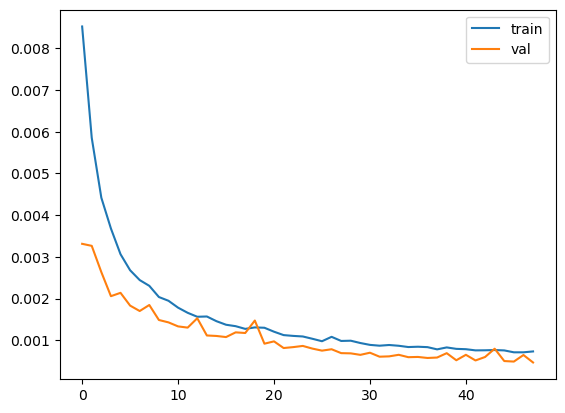

In [75]:
plt.plot(train_loss_per_epoch[2:])
plt.plot(val_loss_per_epoch[2:])
plt.legend(['train','val'])

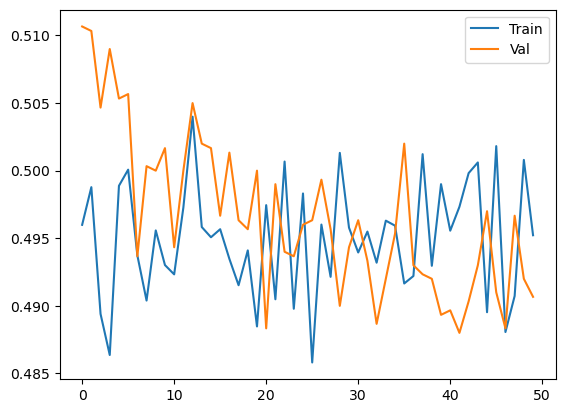

In [44]:
plt.plot(train_winrate)
plt.plot(val_winrate)
plt.legend(['Train','Val'])

In [77]:
predictions1 = scaler_star.inverse_transform(predictions1)

In [79]:
y_val = scaler_star.inverse_transform(y_val)

In [80]:
criterion(torch.Tensor(predictions1),torch.Tensor(y_val)).item()

2.588613271713257

In [82]:
train_loader = DataLoader(train_dataset, batch_size=150, shuffle=False)

model.eval()
predictions2 = []
with torch.no_grad():
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions2.extend(outputs.squeeze().tolist())
predictions2 = np.array(predictions2)

In [83]:
winrate_long(y_train, predictions2)

0.4996501661710687

In [85]:
y_train = scaler_star.inverse_transform(y_train)

In [88]:
predictions2 = scaler_star.inverse_transform(predictions2)

In [89]:
criterion(torch.Tensor(predictions2),torch.Tensor(y_train)).item()

3.383129596710205

In [90]:
torch.save(model.state_dict(), f'ЧВЕСА/[32,57,3,0.1,1]TSMixer(M F=TI) ND|W=0.5025, TL=3.3831 VL=2.5886' )